In [1]:
# Relevant libraries and functions
from __future__ import print_function
import random
import matplotlib.pyplot as plt
import scipy.ndimage
import numpy as np, h5py
import os, time, sys
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import BatchNormalization, Convolution2D, Input, SpatialDropout2D, UpSampling2D, MaxPooling2D, concatenate
from keras.layers.core import Activation, Layer
from keras.layers import Dense, Dropout, Conv1D, Input, Conv2D, add, Conv3D, Reshape
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, CSVLogger
from itertools import cycle
from sklearn import metrics
import skimage
from skimage.metrics import structural_similarity as ssim
#from keras.optimizers import RMSprop
from keras.optimizer_v2 import rmsprop
#from keras.optimizer_v2 import RMSprop
#from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
# from keras.backend.tensorflow_backend import set_session
from keras.backend import set_session
from keras.layers.convolutional import Convolution2D, MaxPooling2D, SeparableConv2D, Conv2DTranspose
import pandas as pd
import scipy.io

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

In [2]:
print(tf.config.experimental.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#import training data

#f_data = '.../trainData' # Directory with trainging data
f_data = r"C:\Users\Arjun Jagota\OneDrive - UHN\Desktop\SourceTreeGTx\gtxDL\DL4FLI-master\FLINET_ex\forwardSimulations\DL2trainingData_10000"
stacks = os.listdir(f_data)
numS = int(len(stacks))

nF = 6 # Number of time-points
xX = 81
yY = 81
nOP = 2

sfdiD = np.ndarray(
        (numS,  int(xX), int(yY), int(nF), int(1)), dtype=np.float32
        )

OP = np.ndarray(
        (numS,  int(xX), int(yY),int(nOP)), dtype=np.float32
        )
depth = np.ndarray(
        (numS, int(xX), int(yY), int(1)), dtype=np.float32
        )
qF = np.ndarray(
        (numS, int(xX), int(yY), int(1)), dtype=np.float32
        )

In [3]:
i = 0;
for d in stacks:
    # Save values to respective mapping
    f = scipy.io.loadmat(os.path.join(f_data,d)) 
    sfdiD[i,:,:,:,0] = f['F']
    f = scipy.io.loadmat(os.path.join(f_data,d)) 
    OP[i,:,:,:] = f['OP']
    f = scipy.io.loadmat(os.path.join(f_data,d)) 
    depth[i,:,:,0] = f['Depth']
    f = scipy.io.loadmat(os.path.join(f_data,d)) 
    qF[i,:,:,0] = f['QF']
    i = i + 1

sfdiD *=10**4
OP[:,:,:,0] *=100
OP[:,:,:,1]*=1/10
qF *= 10**5




In [5]:
# sfdiD.shape
# # OPm.shape
# # f_dat
# sfdiD[100,:,:,:,0]
# tR[1,:,:,0]
# tR.shape
# tR.shape
# depth.shape
# # sfdiD.shape
# np.mean(OP[:,:,:,1])
# # OP[:,:,:,1] *=10
# sfdiD.shape
# # np.mean(OP[:,:,:,1])
# # fig = plt.figure(figsize=(10,10))
# # ax1 = fig.add_subplot(2,2,1)
# # # Predicted amplitude ratio
# # p1 = ax1.imshow(OP[1], interpolation='nearest', vmin=.5, vmax=1.5)
np.mean(qF)

0.44549194

In [4]:
# Relevant resblock functions (Keras API)
def resblock_2D(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

def resblock_2D_BN(num_filters, size_filter, x):
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def resblock_3D_BN(num_filters, size_filter, x):
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = Conv3D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    #output = BatchNormalization()(output)
    output = Activation('relu')(output)
    return output

def xCeptionblock_2D_BN(num_filters, size_filter, x):
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(x)
    Fx = BatchNormalization()(Fx)
    Fx = Activation('relu')(Fx)
    Fx = SeparableConv2D(num_filters, size_filter, padding='same', activation=None)(Fx)
    Fx = BatchNormalization()(Fx)
    output = add([Fx, x])
    output = Activation('relu')(output)
    return output

In [5]:
xX = 81;
yY = 81;
nF = 6;

OpData = Input(shape=(xX,yY,2))
OpProp = OpData
t_data = Input(shape=(xX, yY, nF,1))
sfdi = t_data

OpProp = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(OpProp)
OpProp = Conv2D(128, 1, padding='same', activation=None, data_format="channels_last")(OpProp)
OpProp = Conv2D(128, 1, padding='same', activation=None, data_format="channels_last")(OpProp)


sfdi = Conv3D(50,kernel_size=(1,1,6),strides=(1,1,3), padding='same', activation=None, data_format="channels_last")(sfdi)
sfdi = BatchNormalization()(sfdi)
sfdi = Activation('relu')(sfdi)
sfdi = resblock_3D_BN(50, (1,1,3), sfdi)
sfdi = Reshape((xX,yY,100))(sfdi)
sfdi = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(sfdi)
sfdi = Conv2D(256, 1, padding='same', activation=None, data_format="channels_last")(sfdi)

# concat = concatenate(axis=1)([OpProp, sfdi])
concat = concatenate([OpProp,sfdi],axis=-1)
concat = SeparableConv2D(512, 1, padding='same', activation=None, data_format="channels_last")(concat)

concat = resblock_2D_BN(512, 1, concat) #paper says 256 but it gives an error while 512 does not: 
# "Operands could not be broadcast together with shapes (32, 32, 256) (32, 32, 512)"
concat = resblock_2D_BN(512, 1, concat) 

# Amplitude-Ratio branch
imgqF = Conv2D(64, 1, padding='same', activation=None)(concat)
imgqF = BatchNormalization()(imgqF)
imgqF = Activation('relu')(imgqF)
imgqF = Conv2D(32, 1, padding='same', activation=None)(imgqF)
imgqF = BatchNormalization()(imgqF)
imgqF = Activation('relu')(imgqF)
imgqF = Conv2D(1, 1, padding='same', activation=None)(imgqF)
imgqF = Activation('relu')(imgqF)

# depth Branch 
imgdepth = Conv2D(64, 1, padding='same', activation=None)(concat)
imgdepth = BatchNormalization()(imgdepth)
imgdepth = Activation('relu')(imgdepth)
imgdepth = Conv2D(32, 1, padding='same', activation=None)(imgdepth)
imgdepth = BatchNormalization()(imgdepth)
imgdepth = Activation('relu')(imgdepth)
imgdepth = Conv2D(1, 1, padding='same', activation=None)(imgdepth)
imgdepth = Activation('relu')(imgdepth)

# rmsprop = rmsprop(lr=1e-5)
# _in = [OpData, t_data]
# _out = [imgqF, imgdepth]
# modelD = Model(inputs=[OpData, t_data], outputs=[imgqF, imgdepth]) #, 
# rmspropV = rmsprop.RMSprop(learning_rate=1e-5)

# modelD.compile(loss='mse',
#               optimizer=rmspropV,
#               metrics=['mae'])

modelD = Model(inputs=[OpData,t_data], outputs=[imgqF, imgdepth])
rmspropV = rmsprop.RMSprop(learning_rate=1e-5)

modelD.compile(loss='mse',
              optimizer=rmspropV,
              metrics=['mae'])

In [6]:
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience = 15, 
                              verbose = 0,
                              mode = 'auto')

fN = 'testName' # Assign some name for weights and training/validation loss curves here

# Save loss curve (mse) and MAE information over all trained epochs. (monitor = '' can be changed to focus on other tau parameters)
modelCheckPoint = ModelCheckpoint(filepath=fN+'.h5', 
                                  monitor='val_loss', 
                                  save_best_only=True, 
                                  verbose=0)
# Train network (80/20 train/validation split, batch_size=20 recommended, nb_epoch may vary based on application)
history = History()
csv_logger = CSVLogger(fN+'.log')
history = modelD.fit([OP, sfdiD], [qF, depth],
          validation_split=0.2,
          batch_size=4, epochs=500, verbose=1, shuffle=True, callbacks=[earlyStopping,csv_logger,modelCheckPoint])

Epoch 1/500
2000/2000 [==============================] - 281s 135ms/step - loss: 0.6252 - activation_9_loss: 0.4518 - activation_12_loss: 0.1734 - activation_9_mae: 0.1676 - activation_12_mae: 0.1077 - val_loss: 2.4006 - val_activation_9_loss: 1.9330 - val_activation_12_loss: 0.4676 - val_activation_9_mae: 0.2365 - val_activation_12_mae: 0.1383
Epoch 2/500


C:\Users\Arjun Jagota\miniconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


2000/2000 [==============================] - 261s 131ms/step - loss: 0.4329 - activation_9_loss: 0.3176 - activation_12_loss: 0.1153 - activation_9_mae: 0.1385 - activation_12_mae: 0.0842 - val_loss: 3.7724 - val_activation_9_loss: 2.9107 - val_activation_12_loss: 0.8617 - val_activation_9_mae: 0.4646 - val_activation_12_mae: 0.2491
Epoch 3/500
2000/2000 [==============================] - 262s 131ms/step - loss: 0.3450 - activation_9_loss: 0.2406 - activation_12_loss: 0.1044 - activation_9_mae: 0.1170 - activation_12_mae: 0.0787 - val_loss: 4.3041 - val_activation_9_loss: 2.5353 - val_activation_12_loss: 1.7688 - val_activation_9_mae: 0.5015 - val_activation_12_mae: 0.1977
Epoch 4/500
2000/2000 [==============================] - 262s 131ms/step - loss: 0.3056 - activation_9_loss: 0.2139 - activation_12_loss: 0.0917 - activation_9_mae: 0.1087 - activation_12_mae: 0.0728 - val_loss: 6.1212 - val_activation_9_loss: 1.3242 - val_activation_12_loss: 4.7970 - val_activation_9_mae: 0.2775 - v

In [7]:
modelD.load_weights(fN+'.h5')

In [8]:
modelD.save("modelDL2_10k_k116_s113.h5")

In [4]:
# modelD.load_weights("modelDL2_10000.h5")#10k_k113_s111.h5")

In [11]:
t_data = r"C:\Users\Arjun Jagota\OneDrive - UHN\Desktop\SourceTreeGTx\gtxDL\DL4FLI-master\FLINET_ex\forwardSimulations\DL2testData_50"
stacksT = os.listdir(t_data)
numT = int(len(stacksT))

nF = 6
xX = 81
yY = 81
nOP = 2


sfdiT = np.ndarray(
        (numT, int(xX), int(yY), int(nF), int(1)), dtype=np.float32
        )

OPT = np.ndarray(
        (numT, int(xX), int(yY), int(nOP)), dtype=np.float32
        )
depthT = np.ndarray(
        (numT, int(xX), int(yY), int(1)), dtype=np.float32
        )
qFT = np.ndarray(
        (numT, int(xX), int(yY), int(1)), dtype=np.float32
        )

    
i = 0;
for d in stacksT:
    # Save values to respective mapping
    f = scipy.io.loadmat(os.path.join(t_data,d)) 
    sfdiT[i,:,:,:,0] = f['F']
    f = scipy.io.loadmat(os.path.join(t_data,d)) 
    OPT[i,:,:,:] = f['OP']
    f = scipy.io.loadmat(os.path.join(t_data,d)) 
    depthT[i,:,:,0] = f['Depth']
    f = scipy.io.loadmat(os.path.join(t_data,d)) 
    qFT[i,:,:,0] = f['QF']
    i = i + 1    
# sfdiT =  np.moveaxis(sfdiT, 1, -2)
# OPT = np.moveaxis(OPT,1,-1)
# OPT[:,:,:,1] *=100

sfdiT *=10**4
OPT[:,:,:,0] *=100
OPT[:,:,:,1]*=1/10
qFT *= 10**5

In [ ]:
np.mean(qFT)

In [ ]:
tf.config.experimental.list_physical_devices()

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

In [12]:
# Perform inference on test data with trained model
testV = modelD.predict([OPT, sfdiT])
qFP = testV[0] # Predicted qF values
depthP = testV[1] # Predicted depth values

In [14]:
qFPtrueScale = qFP*10**-5
qFTtrueScale = qFT*10**-5

In [13]:
np.mean(qFTtrueScale)

4.232709e-06

In [ ]:
scipy.io.savemat('PredictedFluorescenceQuantificationDL2_10000.mat',{"quantifiedFluorPredicted":qFPtrueScale})

In [ ]:
scipy.io.savemat('PredictedDepthDL2_10000.mat',{"DepthPredicted":depthP})

In [ ]:
np.mean(qFP[32,:,:])

In [ ]:
# depthP *=10

Text(0.5, 1.0, 'Ground Truth Depth (mm)')

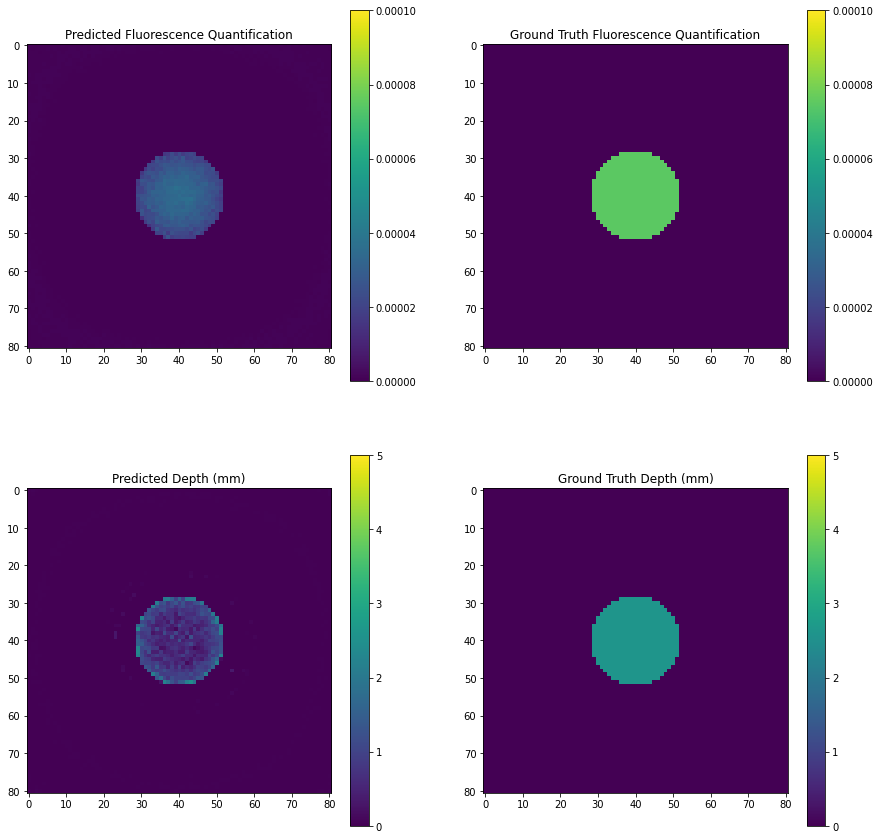

In [26]:


# Visualize example
n = 32 # Number to illustrate w/ matplotlib
fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(2,2,1)
# Predicted qF
p1 = ax1.imshow(qFPtrueScale[n,:,:,0], interpolation='nearest', vmin=.0, vmax=10**-4)
fig.colorbar(p1, ax=ax1)
plt.title('Predicted Fluorescence Quantification')
ax2 = fig.add_subplot(2,2,2)
# G.T. quantified Fluorescence
t1 = ax2.imshow(qFTtrueScale[n,:,:,0], interpolation='nearest', vmin=0, vmax=10**-4)
fig.colorbar(t1, ax=ax2)
plt.title('Ground Truth Fluorescence Quantification')
ax3 = fig.add_subplot(2,2,3)
# Predicted depth
p2 = ax3.imshow(depthP[n,:,:,0], interpolation='nearest', vmin=0, vmax=5)
fig.colorbar(p2, ax=ax3)
plt.title('Predicted Depth (mm)')
# G.T. depth
ax4 = fig.add_subplot(2,2,4)
t2 = ax4.imshow(depthT[n,:,:,0], interpolation='nearest', vmin=0, vmax=5)
fig.colorbar(t2, ax=ax4)
plt.title('Ground Truth Depth (mm)')


In [ ]:
from scipy import io

In [ ]:
np.mean(depthP[0])

array([[0.01970057, 0.04080628, 0.03560751, ..., 0.00257584, 0.00257584,
        0.05739369],
       [0.00257584, 0.01970057, 0.        , ..., 0.00467077, 0.        ,
        0.05348609],
       [0.        , 0.        , 0.        , ..., 0.00257584, 0.        ,
        0.        ],
       ...,
       [0.01415086, 0.        , 0.        , ..., 0.        , 0.        ,
        0.03221231],
       [0.01415086, 0.00834496, 0.01970057, ..., 0.        , 0.        ,
        0.01415086],
       [0.03044868, 0.00834496, 0.05182827, ..., 0.01970057, 0.01415086,
        0.01970057]], dtype=float32)

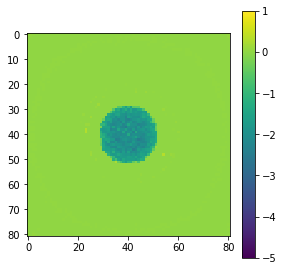

In [27]:
n=32
Diff = depthP[n,:,:,0]-depthT[n,:,:,0]
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
d1=ax1.imshow(Diff[:,:], interpolation='nearest', vmin=-5, vmax=1)
fig.colorbar(d1, ax=ax1)
Diff

In [17]:
zErr = np.zeros((numT,2))
for e in range(numT):
    zErr[e,0] = ssim(depthP[e,:,:,0],depthT[e,:,:,0],multichannel=True)
    nZ = np.unique(depthT[e,:,:,0])
    np.nonzero(nZ)
    zErr[e,1] = nZ[1]

    
tErr = np.zeros((numT,2))
for f in range(numT):
    tErr[f,0] = ssim(qFP[f,:,:,0],qFT[f,:,:,0],multichannel=True)
    nZ = np.unique(depthT[f,:,:,0])
    np.nonzero(nZ)
    tErr[f,1] = nZ[1]    

Text(0.5, 1.0, 'Depth vs SSIM of depth images')

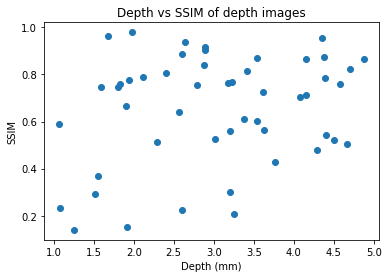

In [18]:
plt.scatter(zErr[:,1],zErr[:,0])
plt.xlabel('Depth (mm)')
plt.ylabel('SSIM')
plt.title('Depth vs SSIM of depth images')

In [19]:
print("Mean of depth SSIM:",np.mean(zErr[:,0]))
print("Standard deviation of depth SSIM:",np.std(zErr[:,0]))
print("Mean of quantified Fluorescence SSIM:",np.mean(tErr[:,0]))
print("Standard deviation of quantified Fluorescence SSIM:",np.std(tErr[:,0]))

Mean of depth SSIM: 0.6552825781565369
Standard deviation of depth SSIM: 0.22818498428647757
Mean of quantified Fluorescence SSIM: 0.6929167353201712
Standard deviation of quantified Fluorescence SSIM: 0.23960819182565093


Text(0.5, 1.0, 'Depth vs SSIM of qF images')

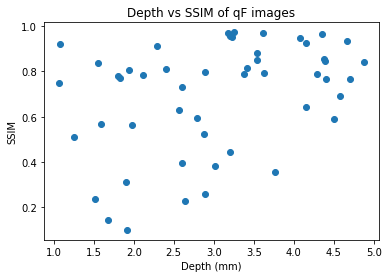

In [20]:
plt.scatter(tErr[:,1],tErr[:,0])
plt.xlabel('Depth (mm)')
plt.ylabel('SSIM')
plt.title('Depth vs SSIM of qF images')

In [21]:
ssim(depthP,depthT,multichannel=True)

0.4403233567304903

In [23]:
ssim(qFP,qFT,multichannel=True)

0.47538793700136145